In [1]:
!pip install niapy==2.5.2 --q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.0/188.0 kB 5.0 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 65.0 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
ydata-profiling 4.17.0 requires matplotlib<=3.10,>=3.5, but you have matplotlib 3.10.7 which is incompatible.
bigframes 2.12.0 requires rich<14,>=12.4.4, but you have rich 14.2.0 which is incompatible.
mlxtend 0.23.4 requires scikit-learn>=1.3.1, but you have scikit-learn 1.2.2 which is incompatible.


In [2]:
!pip install rdkit --q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 44.0 MB/s eta 0:00:00:00:0100:01


In [ ]:
import os
import time
import json
import random
import numpy as np
import warnings
import re

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Embedding, LSTM, Dense, Dropout,
    Conv1D, BatchNormalization, InputLayer
)
from tensorflow.keras.optimizers import Adam, RMSprop, Nadam
from tensorflow.keras.callbacks import (
    EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
)
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2 as l2_reg
from tensorflow.keras.metrics import AUC

from sklearn.model_selection import train_test_split, KFold
from sklearn.utils import compute_class_weight

from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

from niapy.problems import Problem
from niapy.task import OptimizationType, Task
from niapy.algorithms.basic import MonarchButterflyOptimization

from rdkit import Chem
from rdkit.Chem import rdmolfiles


2025-12-04 17:54:35.730095: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764870875.975122      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764870876.047358      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [4]:
df = pd.read_csv('/kaggle/input/gsarpc3/GSARPC3.csv')
df

,cid,smiles,acvalue,categories
0,44244736,COC1=C(C(=C(C=C1)C2=C(OC(=N2)C3=CC=CC=C3F)SC4=...,0.0030,inhibitor
1,44244911,CC1=NN=C(S1)SC2=C(N=C(O2)C3=CC=CC=C3F)C4=C(C(=...,0.0035,inhibitor
2,44245235,COC1=C(C(=C(C=C1)C2=C(OC(=N2)C3=CN=CC=C3)SC4=N...,0.0047,inhibitor
3,10451021,CC(=CC1=CC(=C(C=C1)OC)O)C(=O)C2=CC(=C(C(=C2)OC...,0.0090,inhibitor
4,44245073,CC1=CN=C(N=C1C)SC2=C(N=C(O2)C3=CC=CC=C3Cl)C4=C...,0.0180,inhibitor
...,...,...,...,...
631,145958114,COC1=CC=C(C=C1)C(=O)C=CC2=CC=C(C=C2)N3C=C(N=N3...,100.0000,neutral
632,145950639,C1=CC=C(C=C1)C2=C(N=NC(=N2)SCC3=CN(N=N3)CC4=CC...,100.0000,neutral
633,3168508,C1=CC=C(C=C1)C2=C(N=NC(=N2)SCCC(=O)O)C3=CC=CC=C3,100.0000,neutral
634,145952863,CC(C)CC(C(=O)NO)NC(=O)NCC1=CN(N=N1)CC2=CC=CC=C...,119.1000,neutral


In [5]:
df = pd.read_csv('/kaggle/input/gsarpc3/GSARPC3.csv')
df['smiles'] = df['smiles']

df['target'] = df['categories'].apply(lambda x: 1 if x == "inhibitor" else 0)
print("Distribusi label:")
print(df['target'].value_counts(normalize=True))

df_train, df_test = train_test_split(
    df, test_size=0.2, random_state=42, stratify=df['target']
)


Distribusi label:
target
0    0.504717
1    0.495283
Name: proportion, dtype: float64


In [ ]:
# Augment
def augment_smiles(smiles, n_aug=3):
    """
    Produce up to n_aug randomized SMILES using RDKit's randomization.
    Returns list of unique SMILES.
    """
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return []

    augmented = set()
    for _ in range(n_aug):
        rand_smi = Chem.MolToSmiles(
            mol,
            doRandom=True,
            canonical=False,
            isomericSmiles=True
        )
        augmented.add(rand_smi)

    return list(augmented)


In [7]:
def augment_training_df(df_train, n_aug=3):
    """ #n aug == 3
    Input: original df_train (smiles, target)
    Output: df_train_final (original + augmented)
    """
    augmented_rows = []

    for _, row in df_train.iterrows():
        smi = row['smiles']
        tgt = row['target']

        aug_list = augment_smiles(smi, n_aug=n_aug)

        for aug_smi in aug_list:
            augmented_rows.append([aug_smi, tgt])

    # Convert to DF
    df_aug = pd.DataFrame(augmented_rows, columns=["smiles", "target"])

    # Remove dupes (important)
    df_aug = df_aug.drop_duplicates(subset=["smiles"])

    print(f"Generated augmented SMILES: {len(df_aug)}")

    # Combine original + augmented
    df_train_final = pd.concat([df_train, df_aug], ignore_index=True)

    # Shuffle
    df_train_final = df_train_final.sample(frac=1, random_state=42).reset_index(drop=True)

    print("Final train size:", len(df_train_final))
    return df_train_final

In [9]:
df_train_final = augment_training_df(df_train, n_aug=3)


Generated augmented SMILES: 1524
Final train size: 2032


In [ ]:
# Tokenizer pattern
pattern = re.compile(
    r"(\[[^\]]*\]|Br|Cl|Si|Se|@@?|==?|##?|/|\\|\(|\)|\.|\+|\-|%\d\d|%\d|\d|[A-Z][a-z]?|[a-z])"
)

def tokenize(smiles):
    return pattern.findall(smiles)


all_tokens = []
for s in df_train_final['smiles']:
    toks = tokenize(s)
    all_tokens.extend(toks)

vocab = sorted(set(all_tokens))

token_to_int = {tok: i+2 for i, tok in enumerate(vocab)}  
token_to_int['<PAD>'] = 0
token_to_int['<UNK>'] = 1   

vocab_size = len(token_to_int)
print("vocab_size:", vocab_size)


MAX_LEN = min(250, max(len(tokenize(s)) for s in df_train_final['smiles']) + 5)

def smiles_to_seq(smiles_list, max_len):
    seqs = []
    for s in smiles_list:
        toks = tokenize(s)
        seq = [token_to_int.get(t, 1) for t in toks]

        if len(seq) > max_len:
            seq = seq[:max_len]
        else:
            seq += [0] * (max_len - len(seq))  
        
        seqs.append(seq)

    return np.array(seqs, dtype=np.int32)

X_train = smiles_to_seq(df_train_final['smiles'].tolist(), MAX_LEN)
X_test  = smiles_to_seq(df_test['smiles'].tolist(), MAX_LEN)

y_train = df_train_final['target'].values.astype(np.float32)
y_test  = df_test['target'].values.astype(np.float32)

print(f"X_train: {X_train.shape} | vocab: {vocab_size} | max_len: {MAX_LEN}")


vocab_size: 40
X_train: (2032, 170) | vocab: 40 | max_len: 170


In [12]:
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weight_dict = {int(cls): float(w) for cls, w in zip(classes, weights)}
print("Class weights:", class_weight_dict)


Class weights: {0: 0.9921875, 1: 1.007936507936508}


In [25]:
def build_model(
    embedding_dim=128,
    use_conv=True,
    conv_filters=64,
    conv_kernel_size=5,
    lstm_units=128,    
    dropout_rate=0.3,
    learning_rate=0.001
):
    model = Sequential()
    
    model.add(Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        mask_zero=True
    ))
    
    if use_conv:
        model.add(Conv1D(conv_filters, conv_kernel_size, activation='relu', padding='same'))
        model.add(BatchNormalization())
    
    
    model.add(LSTM(lstm_units, return_sequences=True))
    model.add(LSTM(lstm_units//2, return_sequences=False))
    #model.add(LSTM((lstm_units//2)//2, return_sequences=0))
    #model.add(Dropout(dropout_rate))
    #model.add(Dense(16, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy', 'AUC']
    )
    return model

In [39]:
model = build_model(
    embedding_dim=128,
    use_conv=False,
    conv_filters=64,
    conv_kernel_size=5,
    lstm_units=128,
    dropout_rate=0.3,
    learning_rate=0.0005
)

callbacks = [
    EarlyStopping(monitor='val_AUC', mode='max', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6),  
    ModelCheckpoint('fixed_model.keras', monitor='val_AUC', mode='max', save_best_only=True)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,           
    class_weight=class_weight_dict,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - AUC: 0.5316 - accuracy: 0.5174 - loss: 0.6923 - val_AUC: 0.6498 - val_accuracy: 0.6328 - val_loss: 0.6811 - learning_rate: 5.0000e-04
Epoch 2/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - AUC: 0.6107 - accuracy: 0.5795 - loss: 0.6841 - val_AUC: 0.6929 - val_accuracy: 0.6406 - val_loss: 0.6474 - learning_rate: 5.0000e-04
Epoch 3/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - AUC: 0.6536 - accuracy: 0.6314 - loss: 0.6618 - val_AUC: 0.7314 - val_accuracy: 0.6562 - val_loss: 0.6264 - learning_rate: 5.0000e-04
Epoch 4/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - AUC: 0.6319 - accuracy: 0.5924 - loss: 0.6637 - val_AUC: 0.6976 - val_accuracy: 0.6250 - val_loss: 0.6358 - learning_rate: 5.0000e-04
Epoch 5/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - AUC: 0.6540 - accuracy: 0.6146 - loss: 0.6617 - val_AUC: 0.7328 - val_accuracy: 0.6641 - val_loss: 0.6046 - learning_rate: 5.0000e-04
Epoch 6/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - AUC: 0

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step 

=evaluation
ROC-AUC       : 0.7480
Akurasi       : 0.7031

Classification Report:
              precision    recall  f1-score   support

     Neutral       0.68      0.78      0.73        65
   Inhibitor       0.74      0.62      0.67        63

    accuracy                           0.70       128
   macro avg       0.71      0.70      0.70       128
weighted avg       0.71      0.70      0.70       128



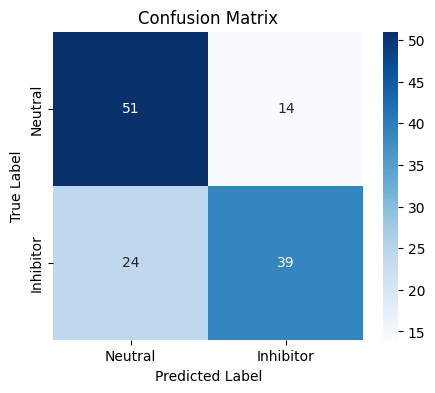

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


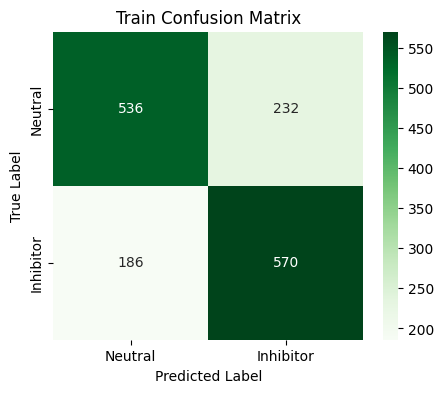

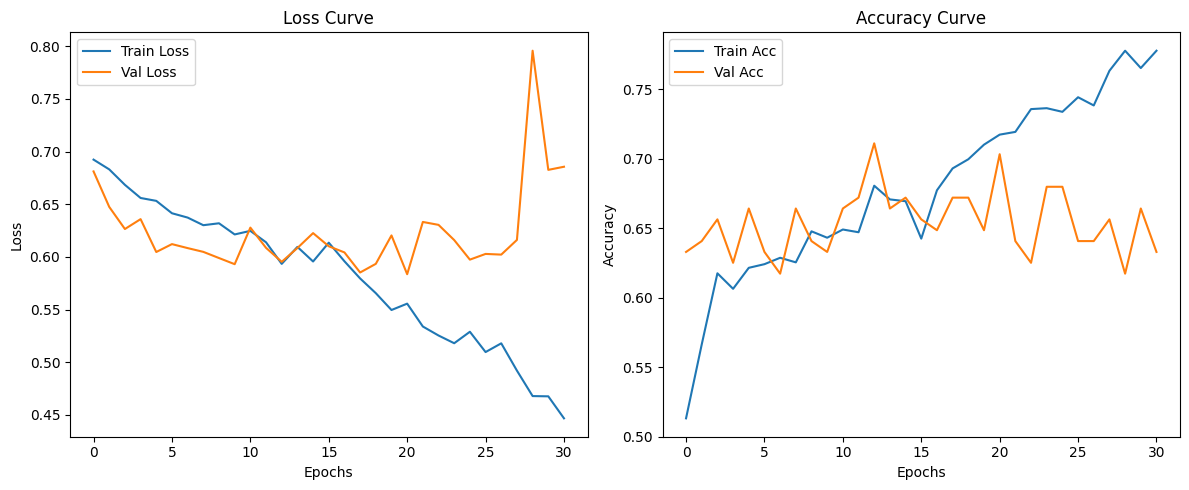

In [40]:
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

y_pred_prob = model.predict(X_test).flatten()
y_pred = (y_pred_prob > 0.5).astype(int)

roc_auc = roc_auc_score(y_test, y_pred_prob)
print("\n=evaluation")
print(f"ROC-AUC       : {roc_auc:.4f}")
print(f"Akurasi       : {np.mean(y_pred == y_test):.4f}\n")

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Neutral', 'Inhibitor']))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Neutral', 'Inhibitor'],
            yticklabels=['Neutral', 'Inhibitor'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

# ====== TRAIN CONFUSION MATRIX ======
y_pred_train_prob = model.predict(X_train).flatten()
y_pred_train = (y_pred_train_prob > 0.5).astype(int)

cm_train = confusion_matrix(y_train, y_pred_train)

plt.figure(figsize=(5,4))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Neutral', 'Inhibitor'],
            yticklabels=['Neutral', 'Inhibitor'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Train Confusion Matrix')
plt.show()

def plot_history(history):
    metrics = [m for m in history.history.keys() if not m.startswith('val_')]
    val_metrics = [f'val_{m}' for m in metrics if f'val_{m}' in history.history]

    plt.figure(figsize=(12,5))
    
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    if 'auc' in history.history:
        plt.subplot(1,2,2)
        plt.plot(history.history['auc'], label='Train AUC')
        plt.plot(history.history['val_auc'], label='Val AUC')
        plt.title('ROC-AUC Curve')
        plt.xlabel('Epochs')
        plt.ylabel('AUC')
        plt.legend()
    else:
        plt.subplot(1,2,2)
        plt.plot(history.history['accuracy'], label='Train Acc')
        plt.plot(history.history['val_accuracy'], label='Val Acc')
        plt.title('Accuracy Curve')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history)


# MBO

In [17]:
def decode_solution(x):
    n_layers = int(np.clip(round(x[0]), 1, 3))
    u1 = int(np.clip(round(x[1]), 16, 192))
    u2 = int(np.clip(round(x[2]), 16, 192))
    u3 = int(np.clip(round(x[3]), 16, 192))
    lr = float(10 ** np.clip(x[4], -3.3, -2.3))

    if n_layers == 1:
        units = (u1,)
    elif n_layers == 2:
        units = (u1, u2)
    else:
        units = (u1, u2, u3)

    return {
        'n_layers': n_layers,
        'units': units,
        'lr': lr
    }

In [ ]:
# build lstm models
def build_lstm_dynamic(params, vocab_size):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=64, mask_zero=True))

    n_layers = params['n_layers']
    units = params['units']

    for i in range(n_layers):
        return_sequences = (i < n_layers - 1)
        model.add(LSTM(units[i], activation='tanh', return_sequences=return_sequences))

    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    return model

In [ ]:
class LSTMHyperparameterOptimization(Problem):
    def __init__(self, X_train, y_train, X_val, y_val, vocab_size, max_epochs=50):
        # dimensinya: n_layers, u1, u2, u3, lr
        super().__init__(dimension=5, lower=0, upper=1)
        self.X_train = X_train
        self.y_train = y_train
        self.X_val = X_val
        self.y_val = y_val
        self.vocab_size = vocab_size
        self.max_epochs = max_epochs

    def _evaluate(self, x):
        params = decode_solution(x)
        model = build_lstm_dynamic(params, self.vocab_size)

        optimizer = Adam(learning_rate=params['lr'])
        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', AUC(name='auc')])

        # Callbacks
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=0)

        try:
            history = model.fit(
                self.X_train, self.y_train,
                epochs=self.max_epochs,
                batch_size=32,
                validation_data=(self.X_val, self.y_val),
                callbacks=[early_stopping, reduce_lr],
                verbose=0
            )
            
            val_loss, val_acc, val_auc = model.evaluate(self.X_val, self.y_val, verbose=0)

            return val_loss
            
        except Exception as e:
            print(f"Error saat mengevaluasi solusi {x}: {e}")
            return float('inf') 

In [ ]:

problem = LSTMHyperparameterOptimization(X_train, y_train, X_test, y_test, vocab_size)

task = Task(problem=problem, max_iters=20, optimization_type=OptimizationType.MINIMIZATION)

algo = MonarchButterflyOptimization(population_size=10, partition=5.0 / 12.0, period=1.2, seed=42)

best_params_vector, best_loss = algo.run(task)

best_params = decode_solution(best_params_vector)

print('Best parameters found by MBO (minimizing loss):', best_params)
print('Best validation loss:', best_loss)

task.plot_convergence(x_axis='iters')

xmod1, ymod1 = task.convergence_data(x_axis='iters')

data_json = json.dumps({
    "evaluation": xmod1.tolist(),
    "fitness": ymod1.tolist()
})

In [ ]:
def build_model(vocab_size,
                embedding_dim=50,
                n_layers=1,
                units=(16,),
                dropout_rate=0.3,
                lr=0.001):
    
    model = Sequential()

    model.add(Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        mask_zero=True
    ))

    for i in range(n_layers):
        return_seq = (i < n_layers - 1)  
        model.add(LSTM(units[i], return_sequences=return_seq))
        model.add(Dropout(dropout_rate))

    model.add(Dense(64, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='binary_crossentropy',
        metrics=['accuracy', AUC(name='AUC')]
    )

    return model


In [ ]:
model = build_model(
    vocab_size=vocab_size,
    embedding_dim=128,
    n_layers=best_params['n_layers'],
    units=best_params['units'],
    dropout_rate=0.2,
    lr=best_params['lr']
)


callbacks = [
    EarlyStopping(monitor='val_AUC', mode='max', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6),  
    ModelCheckpoint('fixed_model.keras', monitor='val_AUC', mode='max', save_best_only=True)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,           
    class_weight=class_weight_dict,
    callbacks=callbacks,
    verbose=0
)

In [ ]:
y_pred_prob = model.predict(X_test).flatten()
y_pred = (y_pred_prob > 0.5).astype(int)

roc_auc = roc_auc_score(y_test, y_pred_prob)
print("\n=evaluation")
print(f"ROC-AUC       : {roc_auc:.4f}")
print(f"Akurasi       : {np.mean(y_pred == y_test):.4f}\n")

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Neutral', 'Inhibitor']))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Neutral', 'Inhibitor'],
            yticklabels=['Neutral', 'Inhibitor'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix - Model 1')
plt.show()

def plot_history(history):
    metrics = [m for m in history.history.keys() if not m.startswith('val_')]
    val_metrics = [f'val_{m}' for m in metrics if f'val_{m}' in history.history]

    plt.figure(figsize=(12,5))
    
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    if 'auc' in history.history:
        plt.subplot(1,2,2)
        plt.plot(history.history['auc'], label='Train AUC')
        plt.plot(history.history['val_auc'], label='Val AUC')
        plt.title('ROC-AUC Curve')
        plt.xlabel('Epochs')
        plt.ylabel('AUC')
        plt.legend()
    else:
        plt.subplot(1,2,2)
        plt.plot(history.history['accuracy'], label='Train Acc')
        plt.plot(history.history['val_accuracy'], label='Val Acc')
        plt.title('Accuracy Curve')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history)
